### Utilisation du modéle GPT 

In [25]:
import pandas as pd
import numpy as np
import torch
from transformers import GPT2Model, GPT2Tokenizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1. Charger les données
df = pd.read_excel("../../Donnees/fichier_traduit.xlsx")

# 2. Préparation des données (similaire à votre code BERTopic)
colonnes_textuelles = ['presentation', 'activites', 'réponse1', 'réponse2']
df[colonnes_textuelles] = df[colonnes_textuelles].fillna("")

def est_vide_ou_espace(val):
    return val.strip() == ""

mask_ligne_vide = df[colonnes_textuelles].applymap(est_vide_ou_espace).all(axis=1)
df = df[~mask_ligne_vide].copy()

# Fusionner les colonnes textuelles
docs = (
    df["presentation"] + " " +
    df["activites"] + " " +
    df["réponse1"] + " " +
    df["réponse2"]
).tolist()

 
 

C:\Users\AnasJB\AppData\Local\Temp\ipykernel_4360\3217850383.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask_ligne_vide = df[colonnes_textuelles].applymap(est_vide_ou_espace).all(axis=1)


In [26]:
# 3. Charger le modèle GPT-2 et le tokenizer
model_name = 'gpt2'  # Vous pouvez aussi utiliser 'gpt2-medium', 'gpt2-large', etc.
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2Model.from_pretrained(model_name)

# Configurer le padding et le truncation
tokenizer.pad_token = tokenizer.eos_token
max_length = 200  # Ajustez selon la longueur de vos documents




c:\Users\AnasJB\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [38]:
# 4. Générer des embeddings
def get_document_embedding(text):
    # Tokeniser et encoder le texte
    inputs = tokenizer(text, return_tensors='pt', 
                       max_length=max_length, 
                       truncation=True, 
                       padding='max_length')
    
    # Obtenir la représentation du modèle
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Moyenne des représentations cachées
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.numpy().flatten()

# Générer les embeddings pour tous les documents
document_embeddings = np.array([get_document_embedding(doc) for doc in docs])

# 5. Réduire la dimensionnalité avec PCA
pca = PCA(n_components=10)  # Réduire à 10 dimensions
reduced_embeddings = pca.fit_transform(document_embeddings)

### Methodes de validation

1) Méthode de coude et Méthode de silhouette

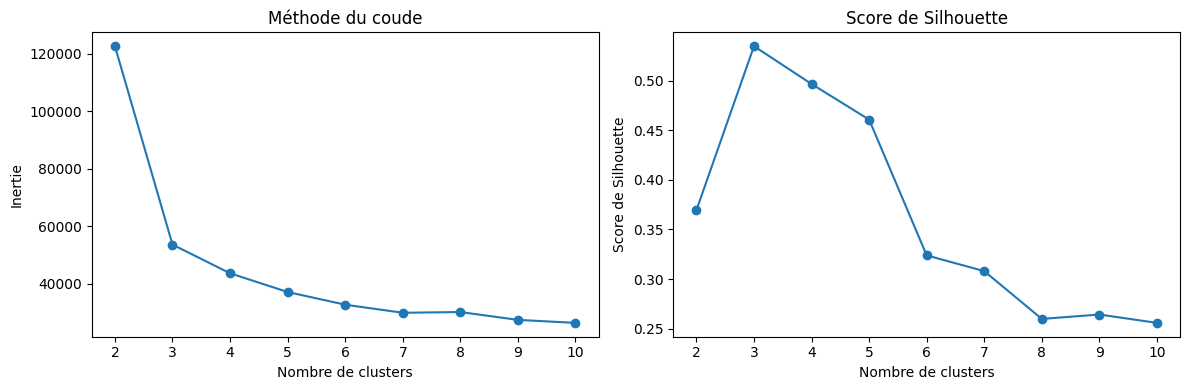

In [33]:
from sklearn.metrics import silhouette_score

inertias = []
silhouette_scores = []
max_clusters = 10

for k in range(2, max_clusters + 1):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_embeddings)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(reduced_embeddings, kmeans.labels_))

# Visualiser les résultats
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(range(2, max_clusters + 1), inertias, marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')

plt.subplot(122)
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Score de Silhouette')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de Silhouette')
plt.tight_layout()
plt.show()

2) Critère d'information bayésien (BIC)



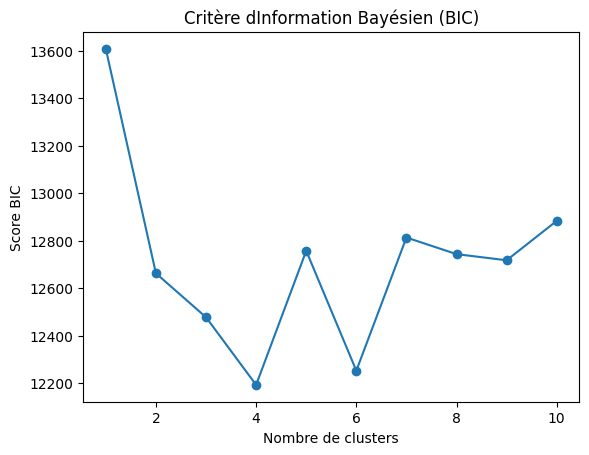

In [31]:
from sklearn.mixture import GaussianMixture

bic_scores = []
max_clusters = 10

for k in range(1, max_clusters + 1):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(reduced_embeddings)
    bic_scores.append(gmm.bic(reduced_embeddings))

plt.plot(range(1, max_clusters + 1), bic_scores, marker='o')
plt.title('Critère dInformation Bayésien (BIC)')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score BIC')
plt.show()

3) Test de stabilité des clusters

Nombre de clusters: 2, Stabilité moyenne: 0.3451
Nombre de clusters: 3, Stabilité moyenne: 1.0000
Nombre de clusters: 4, Stabilité moyenne: 0.8543
Nombre de clusters: 5, Stabilité moyenne: 0.8611
Nombre de clusters: 6, Stabilité moyenne: 0.7635
Nombre de clusters: 7, Stabilité moyenne: 0.6636
Nombre de clusters: 8, Stabilité moyenne: 0.5795
Nombre de clusters: 9, Stabilité moyenne: 0.6314
Nombre de clusters: 10, Stabilité moyenne: 0.6598


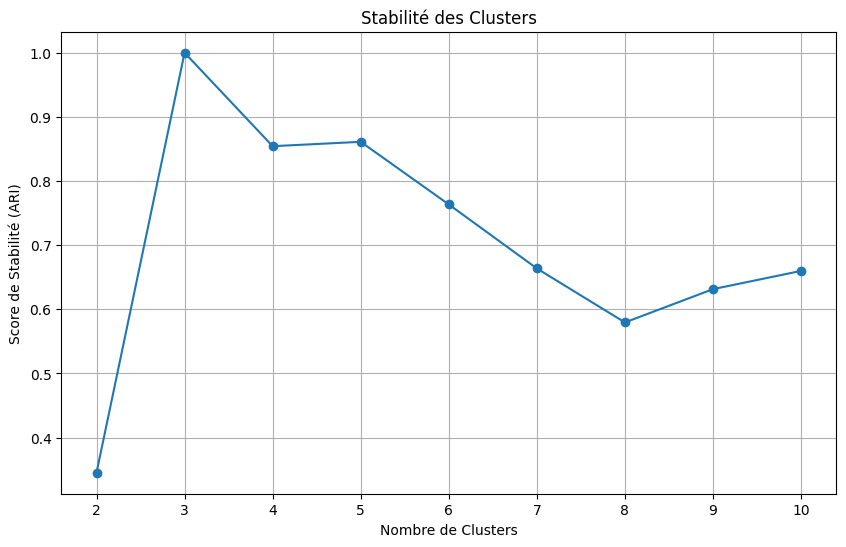

Scores de stabilité : [0.34511982466566576, 1.0, 0.8542758396902158, 0.8610650995023337, 0.7634689275677659, 0.6636361273817452, 0.5794588266734444, 0.6313682328906549, 0.6597892719813967]


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score

def test_stabilite_clusters(X, max_clusters=10, n_runs=5):
    """
    Évalue la stabilité des clusters en exécutant le clustering plusieurs fois
    et en comparant les étiquettes obtenues pour les mêmes données.

    Parameters:
    - X: array-like, shape (n_samples, n_features)
        Données à clusteriser.
    - max_clusters: int, default=10
        Nombre maximum de clusters à tester.
    - n_runs: int, default=5
        Nombre d'exécutions du clustering pour chaque nombre de clusters.

    Returns:
    - stabilite_clusters: list of float
        Scores de stabilité pour chaque nombre de clusters.
    """
    X = np.array(X)
    stabilite_clusters = []
    
    for n_clusters in range(2, max_clusters + 1):
        clusterings = []
        for run in range(n_runs):
            # Changer le random_state pour obtenir des résultats différents
            kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42 + run)
            labels = kmeans.fit_predict(X)
            clusterings.append(labels)
        
        # Calculer les scores ARI entre toutes les paires d'exécutions
        scores = []
        for i in range(n_runs):
            for j in range(i + 1, n_runs):
                score = adjusted_rand_score(clusterings[i], clusterings[j])
                scores.append(score)
        
        # Calculer la moyenne des scores pour ce nombre de clusters
        stabilite = np.mean(scores) if scores else 0
        stabilite_clusters.append(stabilite)
        print(f"Nombre de clusters: {n_clusters}, Stabilité moyenne: {stabilite:.4f}")
    
    # Tracer les résultats
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), stabilite_clusters, marker='o')
    plt.title('Stabilité des Clusters')
    plt.xlabel('Nombre de Clusters')
    plt.ylabel('Score de Stabilité (ARI)')
    plt.xticks(range(2, max_clusters + 1))
    plt.grid(True)
    plt.show()
    
    return stabilite_clusters

# Exemple d'utilisation avec vos embeddings réduits
# Assurez-vous que 'reduced_embeddings' est défini et a la forme appropriée
resultats = test_stabilite_clusters(reduced_embeddings)
print("Scores de stabilité :", resultats)
 

### Clustering


--- Cluster 0 ---
Nombre de documents : 133
Exemples de documents :
                                         presentation  \
6   Le Commissariat est une structure de productio...   
14                                                      
22  Lieu d’exposition en voie de déplacement (LEVD...   

                                            activites  \
6                                                       
14                                                      
22  Né en 2014 de l’initiative de deux artistes pl...   

                                             réponse1  \
6                                                       
14    Immanence a été créé en 1998 à une époque où...   
22                                                      

                                             réponse2  
6                                                      
14    Ce n’est pas parce qu’un lieu est créé et gé...  
22                                                     

--- Cluster 1 ---
N

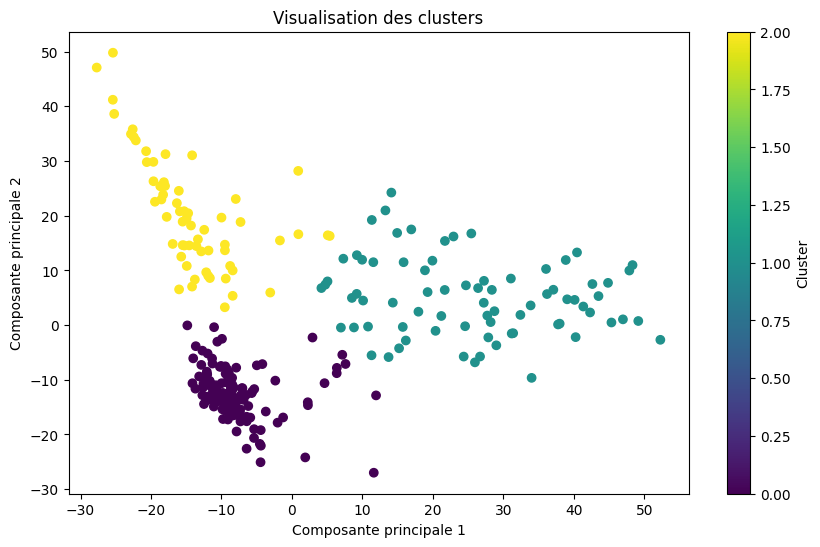

In [42]:
# 6. Clustering avec KMeans
n_clusters = 3  # Ajustez selon vos besoins
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

# 7. Ajouter les clusters au DataFrame
df['cluster'] = clusters

# 8. Analyser les clusters
for i in range(n_clusters):
    print(f"\n--- Cluster {i} ---")
    cluster_docs = df[df['cluster'] == i]
    print(f"Nombre de documents : {len(cluster_docs)}")
    
    # Afficher quelques documents représentatifs
    print("Exemples de documents :")
    print(cluster_docs[colonnes_textuelles].head(3))

# 9. Visualisation (optionnelle)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis')
plt.title('Visualisation des clusters')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(label='Cluster')
plt.show()